In [1]:
# !pip install lightgbm # 3.3.5

In [2]:
# !pip install catboost # '1.1.1'

In [3]:
# !pip install eli5 # '0.13.0'

     ------------------------------------- 216.2/216.2 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107728 sha256=c8e724702581f9ac63c44ab943e3d2f8c952f86c26b89337f769c970edf7e72d
  Stored in directory: c:\users\zxcas\appdata\local\pip\cache\wheels\d0\b5\e0\9c5121f34043df6cbbec39ad10a5f059b75c883bce62a11379
Successfully built eli5


In [4]:
# !pip install mlxtend # '0.19.0'

In [6]:
import gc,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

In [7]:
SEED = 37
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED) # Seed 고정

In [8]:
# data_path = r"/content/drive/MyDrive/lgaimers2/data"
# train_df = pd.read_csv(os.path.join(data_path,'train.csv'))
# test_df = pd.read_csv(os.path.join(data_path,'test.csv'))
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [9]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [10]:
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [11]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

# 이후 LINE과 product_code를 label encoding 해줍니다

In [12]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.15, random_state = 37)
print (f'X_train:{X_train.shape} y_train: {y_train.shape}')
print (f'X_test:{X_test.shape} y_test: {y_test.shape}')

X_train:(508, 2877) y_train: (508,)
X_test:(90, 2877) y_test: (90,)


In [14]:
lgb_params = {
    'metric': 'cross_entropy',
    'n_estimators': 10000,
    'objective': 'softmax',
    'learning_rate': 0.02,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
    'device': 'gpu'
}

rf_params = {
    'max_depth': 7,
    'min_samples_leaf': 10,
    'random_state': 37
}


In [15]:
dt = DecisionTreeClassifier(random_state=SEED) # 42 적혀져 있어서 검증 필요
params = {
    'max_depth':[2,3,4,5,6,7,8,9,10,15,20],
    'min_samples_leaf':[1,2,3,5,6,8,9,10,12,15,20],
    'criterion':['gini','entropy']
}


In [21]:
cl4 = DecisionTreeClassifier(random_state=SEED)
cl5 = CatBoostClassifier(logging_level = 'Silent',random_seed=SEED) # GPU 사용시 돌릴 때 마다 다른 결과 값 나올 수 있음
cl6 = LGBMClassifier(random_state=SEED) 
cl7 = ExtraTreesClassifier(random_state=SEED, bootstrap=False, criterion='entropy', max_features=0.55, min_samples_leaf=8, min_samples_split=4, n_estimators=100) # Optimized using TPOT

In [22]:
from sklearn.model_selection import cross_val_score


In [23]:
RANDOM_SEED = SEED
PROBAS = True
FOLDS = 5
N_ESTIMATORS = 1000

TARGET = 'Y_Class'

# 그냥 기본 적으로 여러가지 방법으로 사용했을때의 결과값

In [24]:
classifiers = {
    "DecisionTree": cl4,
    "CatBoost": cl5,
    "LGBM": cl6,
    "ExtraTrees": cl7,
}
models_scores_results, models_names = list(), list()

In [25]:
print(">>>> Training started <<<<")
for key in classifiers:
    classifier = classifiers[key]
    scores = cross_val_score(classifier, X_train, y_train, cv = FOLDS, scoring='accuracy')
    models_scores_results.append(scores)
    models_names.append(key)
    print("[%s] - accuracy: %0.5f " % (key, scores.mean()))
    classifier.fit(X_train, y_train)
    
    # Save classifier for prediction 
    classifiers[key] = classifier

>>>> Training started <<<<
[DecisionTree] - accuracy: 0.66335 
[CatBoost] - accuracy: 0.78940 
[LGBM] - accuracy: 0.76973 
[ExtraTrees] - accuracy: 0.75779 


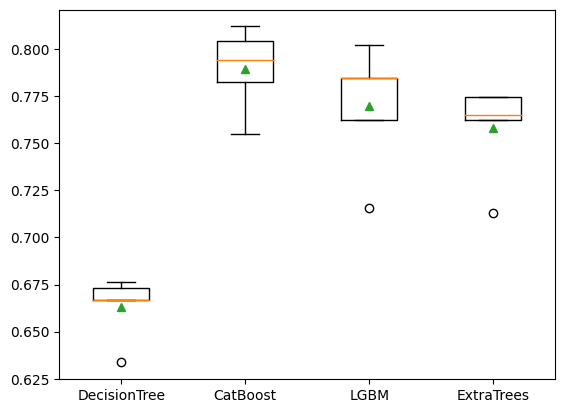

In [26]:
plt.boxplot(models_scores_results, labels=models_names, showmeans=True)
plt.show()

In [27]:
import itertools
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingCVClassifier

In [28]:
import eli5
from eli5.sklearn import PermutationImportance

# 밑의 permutationImportances는 각 모델이 중요하게 살펴보는 지표를 알려주는데 +에서 부터 -까지 나타나있습니다 
# -같은경우는 결과값에 방해를 주기 때문에, 제외하고 너무 많은 column들을 지우게 되다보면 결과값에 영향을 미치게 되어서 0으로 나오는 column들도 포함할수 있도록 기준은 -0.001로 잡았습니다

In [29]:
model=CatBoostClassifier(silent=True, random_state=SEED).fit(X_train, y_train)

In [30]:
perm = PermutationImportance(model, random_state=SEED).fit(X_test, y_test)


In [31]:
minimum_importance = -0.001
mask = perm.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]
X_test = X_test[features]

# 돌려봤을때'LGBM',"DecisionTree",'CatBoost' 의 결과값이 좋았고 이를 이용해서 StackingCVClassifier로 파라미터 찾아주면서 가장 적절한 best모델을 top_meta_model이라고 저장합니다.

In [32]:
best_cls_experiment = [ 'LGBM',"DecisionTree",'CatBoost'] 

In [33]:
print(f'The best models configuration: {best_cls_experiment}')

classifier_exp = []
for label in best_cls_experiment:
        classifier = classifiers[label]
        classifier_exp.append(classifier)

The best models configuration: ['LGBM', 'DecisionTree', 'CatBoost']


In [34]:
classifier_exp

[LGBMClassifier(),
 DecisionTreeClassifier(),

In [35]:
mlr = LogisticRegression()

In [36]:
scl = StackingCVClassifier(classifiers= classifier_exp,
                            meta_classifier = mlr, # use meta-classifier
                            use_probas = PROBAS,   # use_probas = True/False
                            random_state = SEED)

scores = cross_val_score(scl, X_train, y_train, cv = FOLDS, scoring='accuracy')
models_scores_results.append(scores)
models_names.append('scl')
print("Meta model (slc) - accuracy: %0.5f " % (scores.mean()))
scl.fit(X_train, y_train)

top_meta_model = scl
base_acc = scores.mean()

Meta model (slc) - accuracy: 0.78934 


In [ ]:
def meta_best_params_search():
    from sklearn.model_selection import GridSearchCV

    scl_params = {'meta_classifier__C': [0.001,0.01, 0.1, 1, 10, 14, 16]}

    print(">>>> Searching for best parameters started <<<<")

    grid = GridSearchCV(estimator=scl, 
                        param_grid= scl_params, 
                        cv=5,
                        refit=True)
    grid.fit(X_train, y_train)

    cv_keys = ('mean_test_score', 'std_test_score', 'params')

    for r, _ in enumerate(grid.cv_results_['mean_test_score']):
        print("%0.3f +/- %0.2f %r" % (grid.cv_results_[cv_keys[0]][r], grid.cv_results_[cv_keys[1]][r] / 2.0, grid.cv_results_[cv_keys[2]][r]))

    print('Best parameters: %s' % grid.best_params_)
    print('Accuracy: %.5f' % grid.best_score_)
    return grid, grid.best_score_

In [ ]:
hyper_meta_model, hyper_acc = meta_best_params_search()

In [37]:
scl = StackingCVClassifier(classifiers= classifier_exp,
                            meta_classifier = mlr, # use meta-classifier
                            use_probas = PROBAS,   # use_probas = True/False
                            random_state = 37)

scores =cross_val_score(scl, X_train, y_train, cv = FOLDS, scoring='accuracy')
models_scores_results.append(scores)
models_names.append('scl')
print("Meta model (slc) - accuracy: %0.5f " % (scores.mean()))
scl.fit(X_train, y_train)

top_meta_model = scl
base_acc = scores.mean()

Meta model (slc) - accuracy: 0.78148 


# 이제 predict를 해줍니다 

In [38]:
#top_meta_model = hyper_meta_model
classifiers["scl"] = top_meta_model

In [39]:

test_x = test_x[features]
 

In [40]:
test_preds = classifiers['scl'].predict(test_x)[:,]

In [41]:
submission = pd.read_csv('./sample_submission.csv')

In [42]:
submission['Y_Class'] = test_preds

In [43]:
submission.to_csv('./extralgbmcatBoost_remove_test3333.csv', index=False)

In [44]:
submission['Y_Class'].value_counts()

1    266
0     39
2      5
Name: Y_Class, dtype: int64